This python notebook starts to take a look at the genetic similarities between siblings in the iHART and SSC datasets. On average, siblings are 50% genetic, but any given pair of siblings may be slightly more or slighly less genetically related depending upon which copies of their parents' chromosomes they inherited.

Our data is generated from an algorithm using to phase families jointly.
* Code: https://github.com/kpaskov/PhasingFamilies
* Paper (in progress): https://www.overleaf.com/6361338638csmxvgdprkkv

The algorithm was run on all families in iHART of size <= 6 and all families in SSC. Data is available on sherlock
* iHART: /scratch/PI/dpwall/DATA/iHART/kpaskov/PhasingFamilies/phased_ihart_miss
* SSC: /scratch/PI/dpwall/DATA/iHART/kpaskov/PhasingFamilies/phased_ssc_miss

In order to avoid family size confounding, I also broke all iHART families into quads (all-pairs of siblings) and ran the phasing algorithm. Data is available on sherlock
* iHART: /scratch/PI/dpwall/DATA/iHART/kpaskov/PhasingFamilies/phased_ihart_quad

These directories contain the results from the above algorithm. The algorithm is run on each chromosome separately, so the results for each chromosome are in different files. The algorithm also runs on batches of families of the same size. The file chr.1.familysize.5.phased.txt corresponds to all of the data for families of size 5 on chromosome 1.

There are two types of files:
* .families.txt: These files list the individuals in each family. This list is ordered and indicates the order of the children in the phasing output. As a note, the order of the children is randomized per chromosome, so children in the same family may appear in different orders on different chromosomes.
* .phased.txt These files contain the majority of the phasing information. (columns described below, ignore header in file, needs to be fixed)

Columns in .phased.txt files
* family_id: -
* m_1: presence/absence of a deletion on maternal chromosome 1 (0=deletion, 1=no deletion)
* m_2: presence/absence of a deletion on maternal chromosome 2 (0=deletion, 1=no deletion)
* p_1: presence/absence of a deletion on paternal chromosome 1 (0=deletion, 1=no deletion)
* p_2: presence/absence of a deletion on paternal chromosome 2 (0=deletion, 1=no deletion)
* child1_maternal_state: indicates which maternal chromosome was inherited by child1 (0=m1, 1=m2)
* child1_paternal_state: indicates which paternal chromosome was inherited by child1 (0=m1, 1=m2)
* child2_maternal_state: indicates which maternal chromosome was inherited by child2 (0=m1, 1=m2)
* child2_paternal_state: indicates which paternal chromosome was inherited by child2 (0=m1, 1=m2)
* ... (continues for all children in family)
* mask: indicates whether the model fits well in this region (1=bad fit, 0=good fit)
* start_pos: -
* end_pos: -
* start_index: (useless)
* end_index: (useless)
* length of interval: -
* length of interval (in terms of index): (useless)

In [2]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib

In [3]:
# need affected/unaffected information
# these files can be found on sherlock
# '../data/v34.vcf.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/v3.4/v34.vcf.ped
# '../data/ssc.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/SSC/ssc.ped

ped_files = ['../data/v34.vcf.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [4]:
# for this analysis, we remove families with monozygotic multiples

monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
print('Mono multiples', len(monozygotic_multiple_families))

Mono multiples 96


In [5]:
chroms = [str(x) for x in range(1, 23)] #+ ['X']
#chroms = ['15', '22']

ihart_family_sizes = [3, 4, 5, 6]
ihart_phase_dir = '../phased_ihart'

#ihart_quad_family_sizes = [4]
#ihart_quad_phase_dir = '../phased_ihart_quad'

ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc'


In [6]:
# filter families by various criteria

def pull_ok_families(phase_dir, family_sizes):

    # make sure we have data from every chromosome for each family
    family_to_chroms = defaultdict(set)
    family_to_individuals = dict()
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_with_all_chroms = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_with_all_chroms))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    
    # some individuals in iHART have data on WB and LCL, we these families as well, since the phasing algorithm 
    # naively treated these samples as coming from different people - I need to go back and fix this
    families_with_lcl = set([x for x, inds in family_to_individuals.items() if len([y for y in inds if 'LCL' in y]) > 0])
    print('Families with LCL', len(families_with_lcl))
    
    families_to_include = dict([(x, family_to_individuals[x]) for x in families_with_all_chroms if x not in families_with_lcl and x.split('.')[0]  not in monozygotic_multiple_families])
    print('Final families', len(families_to_include))
    
    return families_to_include

ok_ihart_families = pull_ok_families(ihart_phase_dir, ihart_family_sizes)
ok_ssc_families = pull_ok_families(ssc_phase_dir, ssc_family_sizes)
#ok_ihart_quad_families = pull_ok_families(ihart_quad_phase_dir, ihart_quad_family_sizes)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 871
Counter({22: 871})
Families with LCL 0
Final families 788
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 518
Counter({22: 518})
Families with LCL 0
Final families 518


In [7]:
from collections import defaultdict, namedtuple
from uuid import uuid4

# read in phase information
Interval = namedtuple('Interval', ['id', 'chrom', 'start_pos', 'end_pos', 'length', 'has_m1', 'has_m2', 'has_p1', 'has_p2', 'm_unknown', 'p_unknown'])

def load_intervals(phase_dir, family_sizes, families_to_include):
    family_to_intervals = defaultdict(list)
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
                    family_to_individuals = dict()
                    next(f) # skip header
                    num_fams_of_size = 0
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include.keys():
                            family_to_individuals[family_key] = pieces[1:(1+j)]
                            num_fams_of_size += 1

                # load deletions
                with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                    next(f) # skip header

                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include.keys():
                            inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                            start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                            length = end_pos - start_pos + 1

                            has_m1, has_m2, has_p1, has_p2 = [], [], [], []
                            children = family_to_individuals[family_key][2:]
                            if inheritance_state[-1] == 0:
                                for i, child in enumerate(children):
                                    if inheritance_state[4+2*i] == 0:
                                        has_m1.append(child)
                                    elif inheritance_state[4+2*i] == 1:
                                        has_m2.append(child)
                                    if inheritance_state[5+2*i] == 0:
                                        has_p1.append(child)
                                    elif inheritance_state[5+2*i] == 1:
                                        has_p2.append(child)

                            m_unknown = list(set(children) - set(has_m1 + has_m2))
                            p_unknown = list(set(children) - set(has_p1 + has_p2))

                            family_to_intervals[family_key].append(Interval(uuid4(), chrom, start_pos, end_pos, length,
                                                                             has_m1, has_m2, has_p1, has_p2,
                                                                             m_unknown, p_unknown))



            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'fammily size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)
                
    return family_to_intervals

ihart_intervals = load_intervals(ihart_phase_dir, ihart_family_sizes, ok_ihart_families)
ssc_intervals = load_intervals(ssc_phase_dir, ssc_family_sizes, ok_ssc_families)
#ihart_quad_intervals = load_intervals(ihart_quad_phase_dir, ihart_quad_family_sizes, ok_ihart_quad_families)

1 

KeyboardInterrupt: 

In [ ]:
from itertools import product, chain

# calculate maternal and paternal similarity between sibpairs

SibPair = namedtuple('SibPair', ['child1', 'child2', 'shared'])

def calculate_sibpair_similarity(family_to_intervals, family_to_individuals, weights=None):
    sibpairs = dict()

    for family_key, intervals in family_to_intervals.items():
        children = family_to_individuals[family_key][2:]
        for child1 in children:
            for child2 in children:
                if child1 < child2:
                    sibpairs[(child1, child2)] = SibPair(child1, child2, {'mat_same': 0, 'mat_diff': 0, 
                                                                          'pat_same': 0, 'pat_diff': 0,
                                                                         'both_same': 0, 'both_diff': 0})

        for i in intervals:
            if weights is None:
                bp = i.length
            else:
                bp = weights[i.id]
            
            mat_shared = list(chain(product(i.has_m1, repeat=2), product(i.has_m2, repeat=2)))
            for child1, child2 in mat_shared:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['mat_same'] += bp

            mat_different = list(chain(product(i.has_m1, i.has_m2), product(i.has_m2, i.has_m1)))
            for child1, child2 in mat_different:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['mat_diff'] += bp

            pat_shared = list(chain(product(i.has_p1, repeat=2), product(i.has_p2, repeat=2)))
            for child1, child2 in pat_shared:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['pat_same'] += bp

            pat_different = list(chain(product(i.has_p1, i.has_p2), product(i.has_p2, i.has_p1)))
            for child1, child2 in pat_different:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['pat_diff'] += bp

            for child1, child2 in set(mat_shared) & set(pat_shared):
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['both_same'] += bp

            for child1, child2 in set(mat_different) | set(pat_different):
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['both_diff'] += bp
    return sibpairs

ihart_sps = calculate_sibpair_similarity(ihart_intervals, ok_ihart_families)
ssc_sps = calculate_sibpair_similarity(ssc_intervals, ok_ssc_families)
#ihart_quad_sps = calculate_sibpair_similarity(ihart_quad_intervals, ok_ihart_quad_families)

Outliers iHART 0 iHART quad 0 SSC 0


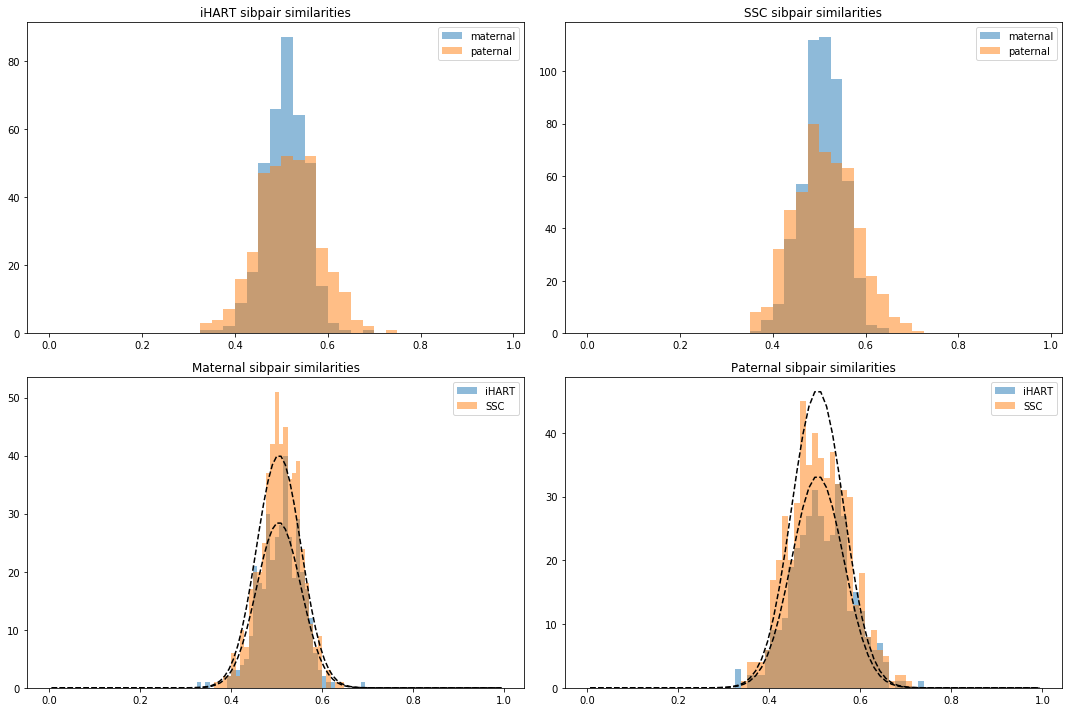

In [10]:
import scipy.stats as stats

ihart_sps_keys = sorted(ihart_sps.keys())
ssc_sps_keys = sorted(ssc_sps.keys())

ihart_mat = [x.shared['mat_same']/(x.shared['mat_same']+x.shared['mat_diff']) for x in [ihart_sps[y] for y in ihart_sps_keys]]
ihart_pat = [x.shared['pat_same']/(x.shared['pat_same']+x.shared['pat_diff']) for x in [ihart_sps[y] for y in ihart_sps_keys]]
ihart_both = [x.shared['both_same']/(x.shared['both_same']+x.shared['both_diff']) for x in [ihart_sps[y] for y in ihart_sps_keys]]

ssc_mat = [x.shared['mat_same']/(x.shared['mat_same']+x.shared['mat_diff']) for x in [ssc_sps[y] for y in ssc_sps_keys]]
ssc_pat = [x.shared['pat_same']/(x.shared['pat_same']+x.shared['pat_diff']) for x in [ssc_sps[y] for y in ssc_sps_keys]]
ssc_both = [x.shared['both_same']/(x.shared['both_same']+x.shared['both_diff']) for x in [ssc_sps[y] for y in ssc_sps_keys]]

ihart_quad_mat = [0 if x is None else x.shared['mat_same']/(x.shared['mat_same']+x.shared['mat_diff']) for x in [None if y not in ihart_quad_sps else ihart_quad_sps[y] for y in ihart_sps_keys]]
ihart_quad_pat = [0 if x is None else x.shared['pat_same']/(x.shared['pat_same']+x.shared['pat_diff']) for x in [None if y not in ihart_quad_sps else ihart_quad_sps[y] for y in ihart_sps_keys]]
ihart_quad_both = [0 if x is None else x.shared['both_same']/(x.shared['both_same']+x.shared['both_diff']) for x in [None if y not in ihart_quad_sps else ihart_quad_sps[y] for y in ihart_sps_keys]]

#ihart_outliers = [x for x, m_mat, m_pat in zip(ihart_sps_keys, ihart_mat, ihart_pat) if m_mat > 0.7 or m_mat < 0.2 or m_pat > 0.7 or m_pat < 0.2]
#ihart_quad_outliers = [x for x, m_mat, m_pat in zip(ihart_sps_keys, ihart_quad_mat, ihart_quad_pat) if m_mat > 0.7 or m_mat < 0.2 or m_pat > 0.7 or m_pat < 0.2]
#ssc_outliers = [x for x, m_mat, m_pat in zip(ssc_sps_keys, ssc_mat, ssc_pat) if m_mat > 0.7 or m_mat < 0.2 or m_pat > 0.7 or m_pat < 0.2]
ihart_outliers, ihart_quad_outliers, ssc_outliers = [], [], []

print('Outliers', 'iHART', len(ihart_outliers), 'iHART quad', len(ihart_quad_outliers), 'SSC', len(ssc_outliers))
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(ihart_mat, bins=np.arange(0, 1, .025), alpha=0.5, label='maternal')
plt.hist(ihart_pat, bins=np.arange(0, 1, .025), alpha=0.5, label='paternal')
plt.title('iHART sibpair similarities')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(ssc_mat, bins=np.arange(0, 1, .025), alpha=0.5, label='maternal')
plt.hist(ssc_pat, bins=np.arange(0, 1, .025), alpha=0.5, label='paternal')
plt.title('SSC sibpair similarities')
plt.legend()

plt.subplot(2, 2, 3)
p = 0.5
n = (21+(2*42))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_mat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ssc_mat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Maternal sibpair similarities')

plt.subplot(2, 2, 4)
n = (21+(2*28))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_pat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ssc_pat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Paternal sibpair similarities')

plt.tight_layout()
plt.show()

iHART aff-aff 347
iHART aff-unaff 19
iHART unaff-unaff 1
SSC aff-unaff 516


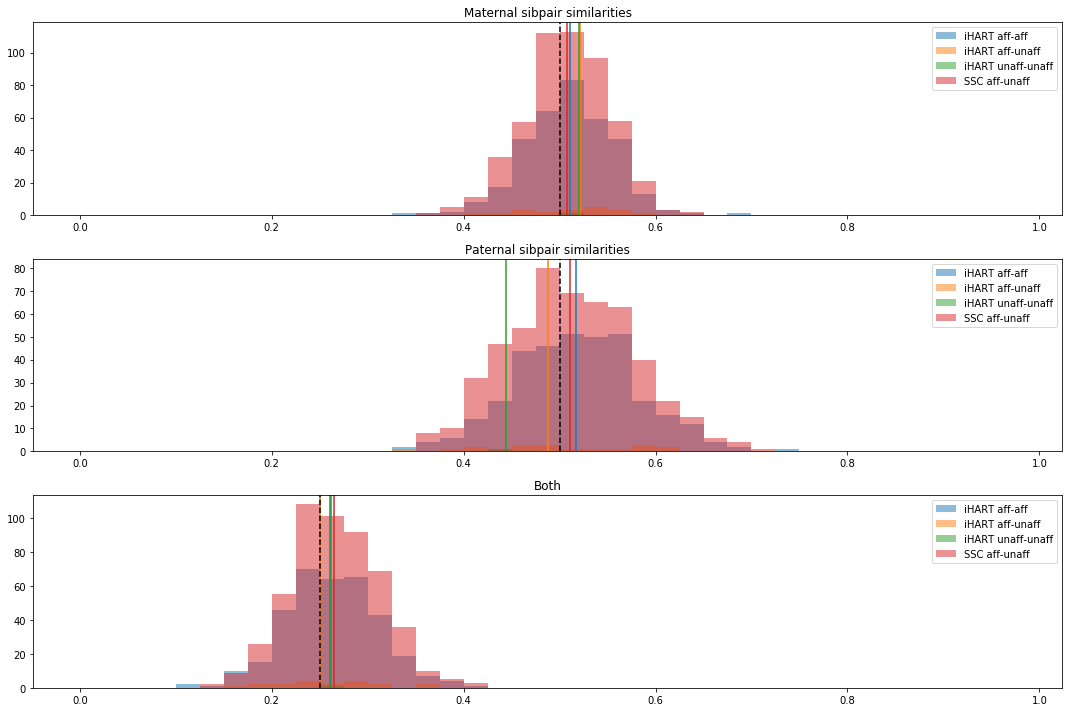

In [11]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 10))

ihart_mat_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_mat) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2' and x not in ihart_outliers]
ihart_mat_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_mat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ihart_outliers]
ihart_mat_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_mat) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1' and x not in ihart_outliers]

ihart_pat_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_pat) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2' and x not in ihart_outliers]
ihart_pat_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_pat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ihart_outliers]
ihart_pat_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_pat) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1' and x not in ihart_outliers]

ihart_both_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_both) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2' and x not in ihart_outliers]
ihart_both_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_both) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ihart_outliers]
ihart_both_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_both) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1' and x not in ihart_outliers]

ssc_mat_aff_unaff = [m for x, m in zip(ssc_sps_keys, ssc_mat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ssc_outliers]
ssc_pat_aff_unaff = [m for x, m in zip(ssc_sps_keys, ssc_pat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ssc_outliers]
ssc_both_aff_unaff = [m for x, m in zip(ssc_sps_keys, ssc_both) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ssc_outliers]

print('iHART aff-aff', len(ihart_mat_aff_aff))
print('iHART aff-unaff', len(ihart_mat_aff_unaff))
print('iHART unaff-unaff', len(ihart_mat_unaff_unaff))
print('SSC aff-unaff', len(ssc_mat_aff_unaff))

plt.subplot(3, 1, 1)
plt.title('Maternal sibpair similarities')
plt.hist(ihart_mat_aff_aff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_mat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-unaff')
plt.hist(ihart_mat_unaff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_mat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='SSC aff-unaff')
plt.axvline(np.median(ihart_mat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_mat_aff_unaff), color=colors[1])
plt.axvline(np.median(ihart_mat_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_mat_aff_unaff), color=colors[3])
plt.axvline(0.5, color='black', linestyle='--')

#m = 0.5
#s = max(np.std(ihart_mat_aff_aff), np.std(ihart_mat_aff_unaff), np.std(ssc_mat_aff_unaff))
#n = min(len(ihart_mat_aff_aff), len(ihart_mat_aff_unaff), len(ssc_mat_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.subplot(3, 1, 2)
plt.title('Paternal sibpair similarities')
plt.hist(ihart_pat_aff_aff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_pat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-unaff')
plt.hist(ihart_pat_unaff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_pat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='SSC aff-unaff')

plt.axvline(np.median(ihart_pat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_pat_aff_unaff), color=colors[1])
plt.axvline(np.median(ihart_pat_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_pat_aff_unaff), color=colors[3])
plt.axvline(0.5, color='black', linestyle='--')

#m = 0.5
#s = max(np.std(ihart_pat_aff_aff), np.std(ihart_pat_aff_unaff), np.std(ssc_pat_aff_unaff))
#n = min(len(ihart_pat_aff_aff), len(ihart_pat_aff_unaff), len(ssc_pat_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.subplot(3, 1, 3)
plt.title('Both')
plt.hist(ihart_both_aff_aff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_both_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-unaff')
plt.hist(ihart_both_unaff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_both_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='SSC aff-unaff')
plt.axvline(np.median(ihart_both_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_both_aff_unaff), color=colors[1])
plt.axvline(np.median(ihart_both_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_both_aff_unaff), color=colors[3])
plt.axvline(0.25, color='black', linestyle='--')

#m = 0.25
#s = max(np.std(ihart_both_aff_aff), np.std(ihart_both_aff_unaff), np.std(ssc_both_aff_unaff))
#n = min(len(ihart_both_aff_aff), len(ihart_both_aff_unaff), len(ssc_both_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.tight_layout()
plt.show()



In [12]:
from scipy import stats

print(stats.ttest_ind(ihart_mat_aff_aff, ihart_mat_aff_unaff, equal_var=True))
print(stats.ttest_ind(ihart_pat_aff_aff, ihart_pat_aff_unaff, equal_var=True))
print(stats.ttest_ind(ihart_both_aff_aff, ihart_both_aff_unaff, equal_var=True))


Ttest_indResult(statistic=-0.26399513465066904, pvalue=0.79193306501905414)
Ttest_indResult(statistic=1.3961620622847497, pvalue=0.16351656486578509)
Ttest_indResult(statistic=0.20161765431617124, pvalue=0.84032826645160674)


# Is family size a confounder?

//anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
//anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


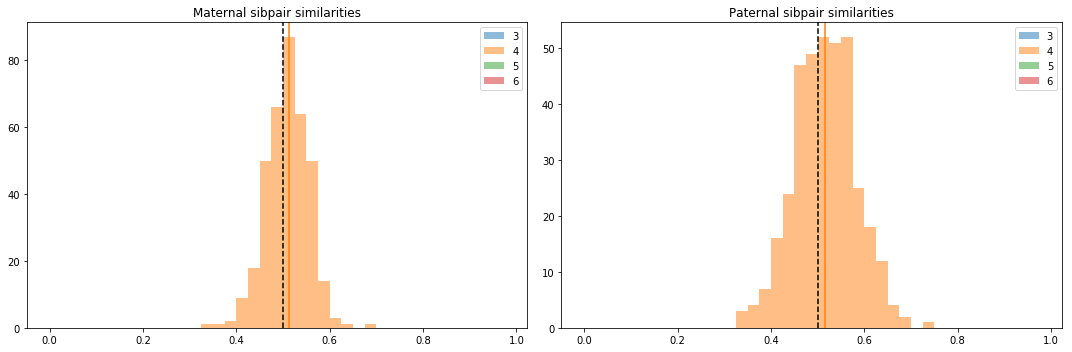

In [13]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# for iHART, break it down by family size
child_to_family_size = dict()
for inds in ok_ihart_families.values():
    for child in inds[2:]:
        child_to_family_size[child] = len(inds)
        
plt.figure(figsize=(15, 5))

for i, j in enumerate(ihart_family_sizes):
    
    m = [x for s, x in zip(ihart_sps_keys, ihart_mat) if child_to_family_size[s[0]]==j]
    p = [x for s, x in zip(ihart_sps_keys, ihart_pat) if child_to_family_size[s[0]]==j]
    b = [x for s, x in zip(ihart_sps_keys, ihart_both) if child_to_family_size[s[0]]==j]
    
    plt.subplot(1, 2, 1)
    plt.hist(m, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    plt.axvline(np.median(m), color=colors[i])
    
    plt.subplot(1, 2, 2)
    plt.hist(p, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    plt.axvline(np.median(p), color=colors[i])

plt.subplot(1, 2, 1)
plt.legend()
plt.axvline(0.5, color='black', linestyle='--')
plt.title('Maternal sibpair similarities')

plt.subplot(1, 2, 2)
plt.legend()
plt.axvline(0.5, color='black', linestyle='--')
plt.title('Paternal sibpair similarities')

plt.tight_layout()
plt.show()

We see a subtle relationship between family size and sibpair similarity in iHART with smaller families having more similar sibpairs than we would expect. This could point to family size somehow confounding the aff-aff aff-unaff relationships we saw above, and may explain why iHART seems to hae more similar sibpairs than we would expect. However, if aff-aff sibpairs really are more similar, then this pattern could simply be explained by family structure. Since it's a multiplex cohort, smaller families will have more aff-aff pairs than larger ones, explaining the pattern in this plot.

There are a couple of ways to test what's going on. One would be to look at aff-aff and aff-unaff sibpairs 

aff-aff 3 nan nan
aff-unaff 3 nan nan
aff-aff 4 0.510605103934 0.516827771631
aff-unaff 4 0.521113202526 0.48779749502
aff-aff 5 nan nan
aff-unaff 5 nan nan
aff-aff 6 nan nan
aff-unaff 6 nan nan


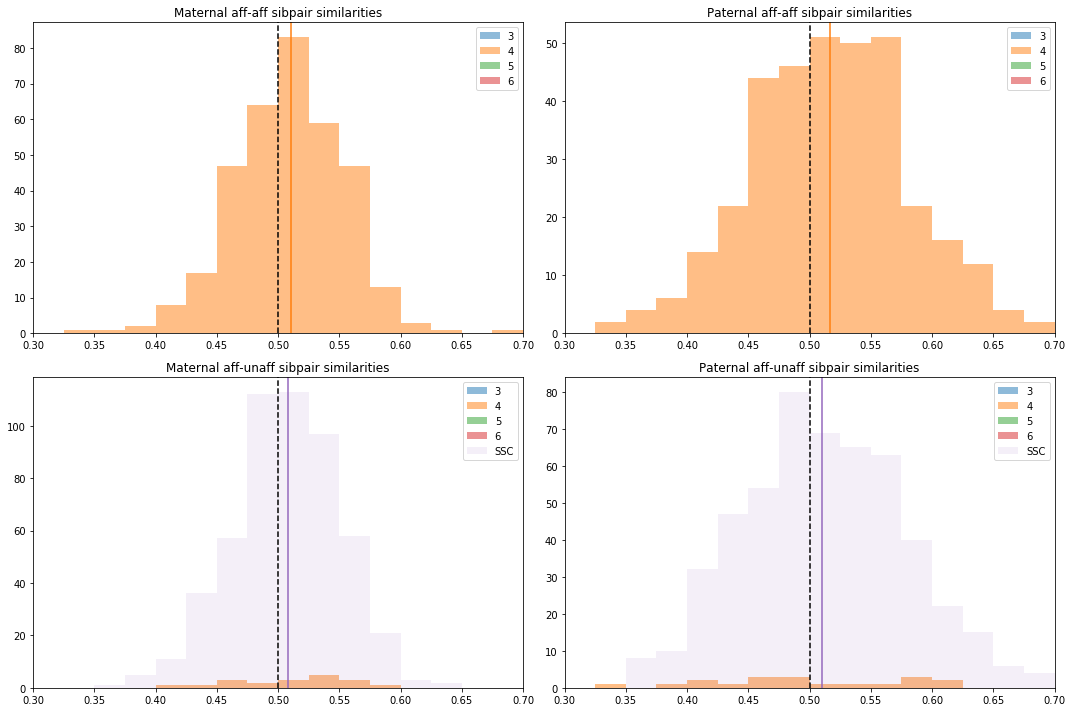

In [14]:
plt.figure(figsize=(15, 10))

for i, j in enumerate(ihart_family_sizes):
    
    m = [x for s, x in zip(ihart_sps_keys, ihart_mat) if child_to_family_size[s[0]]==j and child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '2']
    p = [x for s, x in zip(ihart_sps_keys, ihart_pat) if child_to_family_size[s[0]]==j and child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '2']
    
    plt.subplot(2, 2, 1)
    plt.hist(m, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    plt.axvline(np.median(m), color=colors[i])
    
    plt.subplot(2, 2, 2)
    plt.hist(p, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    plt.axvline(np.median(p), color=colors[i])
    
    print('aff-aff %d' % j, np.median(m), np.median(p))
    
    m = [x for s, x in zip(ihart_sps_keys, ihart_mat) if child_to_family_size[s[0]]==j and ((child_id_to_affected[s[0]] == '1' and child_id_to_affected[s[1]] == '2') or (child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '1'))]
    p = [x for s, x in zip(ihart_sps_keys, ihart_pat) if child_to_family_size[s[0]]==j and ((child_id_to_affected[s[0]] == '1' and child_id_to_affected[s[1]] == '2') or (child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '1'))]
    
    plt.subplot(2, 2, 3)
    plt.hist(m, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    if len(p) > 20:
        plt.axvline(np.median(m), color=colors[i])
    
    plt.subplot(2, 2, 4)
    plt.hist(p, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    
    if len(p) > 20:
        plt.axvline(np.median(p), color=colors[i])
    
    print('aff-unaff %d' % j, np.median(m), np.median(p))
    
plt.subplot(2, 2, 3)
plt.hist(ssc_mat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.1, label='SSC')
plt.axvline(np.median(ssc_mat_aff_unaff), color=colors[i+1])

plt.subplot(2, 2, 4)
plt.hist(ssc_pat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.1, label='SSC')
plt.axvline(np.median(ssc_pat_aff_unaff), color=colors[i+1])

plt.subplot(2, 2, 1)
plt.legend()
plt.axvline(0.5, color='black', linestyle='--')
plt.title('Maternal aff-aff sibpair similarities')
plt.xlim([0.3, 0.7])

plt.subplot(2, 2, 2)
plt.legend()
plt.axvline(0.5, color='black', linestyle='--')
plt.title('Paternal aff-aff sibpair similarities')
plt.xlim([0.3, 0.7])

plt.subplot(2, 2, 3)
plt.legend()
plt.axvline(0.5, color='black', linestyle='--')
plt.title('Maternal aff-unaff sibpair similarities')
plt.xlim([0.3, 0.7])

plt.subplot(2, 2, 4)
plt.legend()
plt.axvline(0.5, color='black', linestyle='--')
plt.title('Paternal aff-unaff sibpair similarities')
plt.xlim([0.3, 0.7])

plt.tight_layout()
plt.show()

aff-aff 3 nan
aff-unaff 3 nan
aff-aff 4 0.260753183715
aff-unaff 4 0.250299803866
aff-aff 5 nan
aff-unaff 5 nan
aff-aff 6 nan
aff-unaff 6 nan


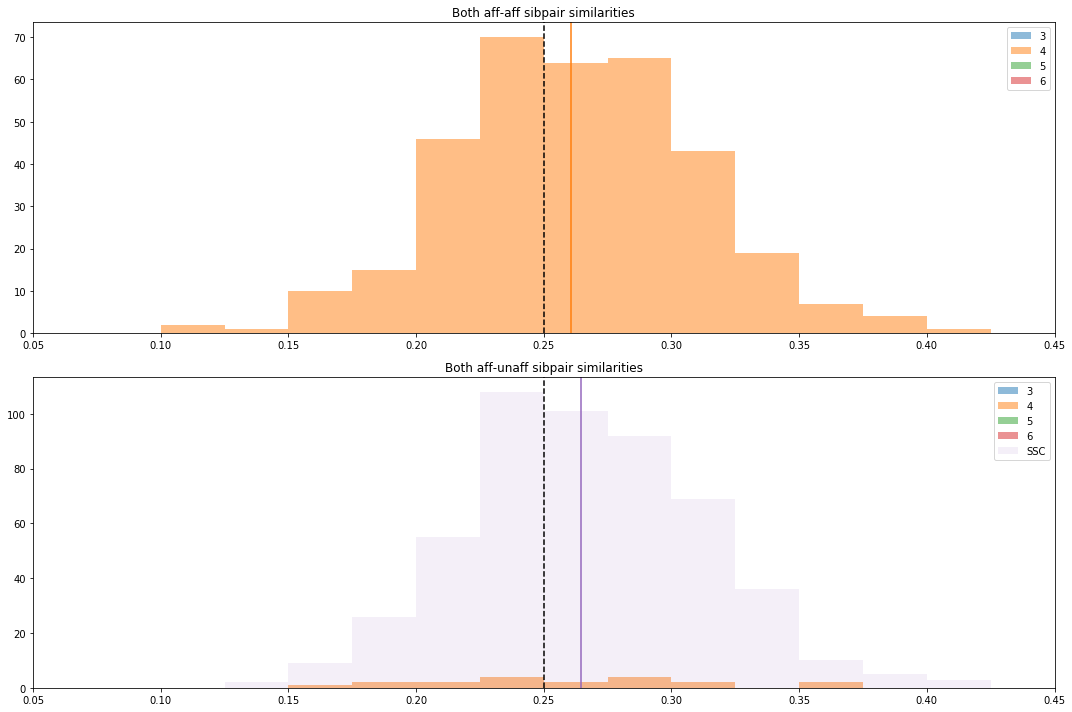

In [15]:
plt.figure(figsize=(15, 10))

for i, j in enumerate(ihart_family_sizes):
    
    b = [x for s, x in zip(ihart_sps_keys, ihart_both) if child_to_family_size[s[0]]==j and child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '2']
    
    plt.subplot(2, 1, 1)
    plt.hist(b, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    plt.axvline(np.median(b), color=colors[i])

    print('aff-aff %d' % j, np.median(b))
    
    b = [x for s, x in zip(ihart_sps_keys, ihart_both) if child_to_family_size[s[0]]==j and ((child_id_to_affected[s[0]] == '1' and child_id_to_affected[s[1]] == '2') or (child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '1'))]
    
    plt.subplot(2, 1, 2)
    plt.hist(b, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    
    if len(b)>20:
        plt.axvline(np.median(b), color=colors[i])
    
    print('aff-unaff %d' % j, np.median(b))
    
plt.hist(ssc_both_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.1, label='SSC')
plt.axvline(np.median(ssc_both_aff_unaff), color=colors[i+1])

plt.subplot(2, 1, 1)
plt.legend()
plt.axvline(0.25, color='black', linestyle='--')
plt.title('Both aff-aff sibpair similarities')
plt.xlim([0.05, 0.45])

plt.subplot(2, 1, 2)
plt.legend()
plt.axvline(0.25, color='black', linestyle='--')
plt.title('Both aff-unaff sibpair similarities')
plt.xlim([0.05, 0.45])

plt.tight_layout()
plt.show()

In [16]:
print('highly similar maternal', [s for s, x in zip(ihart_sps_keys, ihart_mat) if x>0.75])
print('highly similar paternal', [s for s, x in zip(ihart_sps_keys, ihart_pat) if x>0.75])


highly similar maternal []
highly similar paternal []


In [17]:
from scipy import stats

m_aa = [x for s, x in zip(ihart_sps_keys, ihart_mat) if child_to_family_size[s[0]]>4 and child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '2']
p_aa = [x for s, x in zip(ihart_sps_keys, ihart_pat) if child_to_family_size[s[0]]>4 and child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '2']
b_aa = [x for s, x in zip(ihart_sps_keys, ihart_both) if child_to_family_size[s[0]]>4 and child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '2']

m_au = [x for s, x in zip(ihart_sps_keys, ihart_mat) if child_to_family_size[s[0]]>4 and ((child_id_to_affected[s[0]] == '1' and child_id_to_affected[s[1]] == '2') or (child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '1'))]
p_au = [x for s, x in zip(ihart_sps_keys, ihart_pat) if child_to_family_size[s[0]]>4 and ((child_id_to_affected[s[0]] == '1' and child_id_to_affected[s[1]] == '2') or (child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '1'))]
b_au = [x for s, x in zip(ihart_sps_keys, ihart_both) if child_to_family_size[s[0]]>4 and ((child_id_to_affected[s[0]] == '1' and child_id_to_affected[s[1]] == '2') or (child_id_to_affected[s[0]] == '2' and child_id_to_affected[s[1]] == '1'))]

print(len(m_aa), len(m_au))
print(len(ihart_mat_aff_aff), len(ihart_mat_aff_unaff))
print(stats.ttest_ind(m_aa, m_au, equal_var=False))
print(stats.ttest_ind(p_aa, p_au, equal_var=False))
print(stats.ttest_ind(b_aa, b_au, equal_var=False))


0 0
347 19
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)


# Try using only quad families

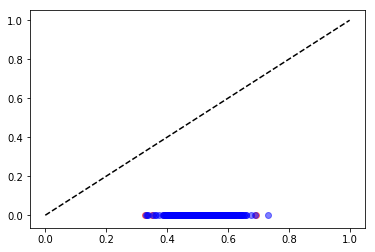

In [18]:
plt.scatter(ihart_mat, ihart_quad_mat, color='red', alpha=0.5)
plt.scatter(ihart_pat, ihart_quad_pat, color='blue', alpha=0.5)
plt.plot([0, 1], [0, 1], ls="--", color='black')
plt.show()

iHART quad aff-aff 643
iHART quad aff-unaff 361
iHART quad unaff-unaff 19
SSC aff-unaff 515


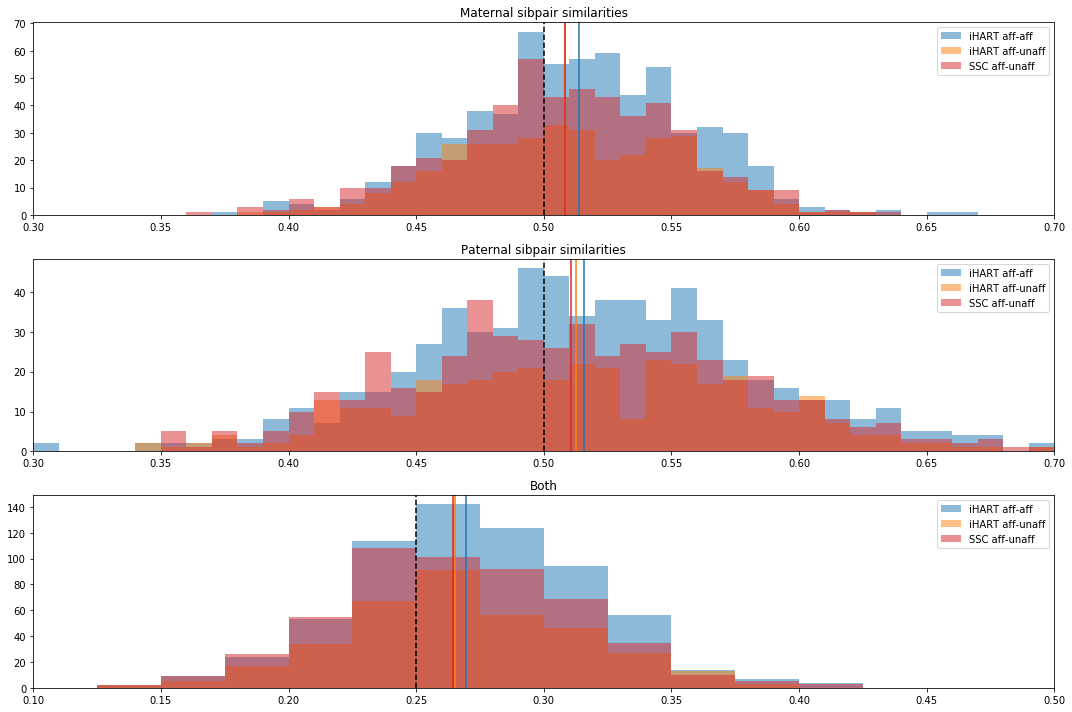

In [28]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 10))

ihart_quad_mat_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_quad_mat) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2' and x not in ihart_quad_outliers]
ihart_quad_mat_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_mat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1'))  and x not in ihart_quad_outliers]
ihart_quad_mat_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_mat) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1'  and x not in ihart_quad_outliers]

ihart_quad_pat_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_quad_pat) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2' and x not in ihart_quad_outliers]
ihart_quad_pat_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_pat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ihart_quad_outliers]
ihart_quad_pat_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_pat) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1' and x not in ihart_quad_outliers]

ihart_quad_both_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_quad_both) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2' and x not in ihart_quad_outliers]
ihart_quad_both_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_both) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ihart_quad_outliers]
ihart_quad_both_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_both) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1' and x not in ihart_quad_outliers]

print('iHART quad aff-aff', len(ihart_quad_mat_aff_aff))
print('iHART quad aff-unaff', len(ihart_quad_mat_aff_unaff))
print('iHART quad unaff-unaff', len(ihart_quad_mat_unaff_unaff))
print('SSC aff-unaff', len(ssc_mat_aff_unaff))

plt.subplot(3, 1, 1)
plt.title('Maternal sibpair similarities')
plt.hist(ihart_quad_mat_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_quad_mat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART aff-unaff')
#plt.hist(ihart_quad_mat_unaff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_mat_aff_unaff, bins=np.arange(0, 1, .01), color=colors[3], alpha=0.5, label='SSC aff-unaff')
plt.axvline(np.median(ihart_quad_mat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_mat_aff_unaff), color=colors[1])
#plt.axvline(np.median(ihart_quad_mat_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_mat_aff_unaff), color=colors[3])

#plt.axvline(np.median(ihart_quad_mat_aff_aff+ihart_quad_mat_unaff_unaff+ihart_quad_mat_aff_unaff+ssc_mat_aff_unaff), color='black')
#plt.axvline(np.median(ihart_quad_mat_aff_unaff+ssc_mat_aff_unaff), color='white')
#plt.axvline(np.median(ihart_quad_mat_aff_aff+ihart_quad_mat_unaff_unaff), color='gray')

plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0.3, 0.7])

#m = 0.5
#s = max(np.std(ihart_mat_aff_aff), np.std(ihart_mat_aff_unaff), np.std(ssc_mat_aff_unaff))
#n = min(len(ihart_mat_aff_aff), len(ihart_mat_aff_unaff), len(ssc_mat_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.subplot(3, 1, 2)
plt.title('Paternal sibpair similarities')
plt.hist(ihart_quad_pat_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_quad_pat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART aff-unaff')
#plt.hist(ihart_quad_pat_unaff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_pat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, color=colors[3], label='SSC aff-unaff')

plt.axvline(np.median(ihart_quad_pat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_pat_aff_unaff), color=colors[1])
#plt.axvline(np.median(ihart_quad_pat_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_pat_aff_unaff), color=colors[3])

#plt.axvline(np.median(ihart_quad_pat_aff_aff+ihart_quad_pat_unaff_unaff+ihart_quad_pat_aff_unaff+ssc_pat_aff_unaff), color='black')
#plt.axvline(np.median(ihart_quad_pat_aff_unaff+ssc_pat_aff_unaff), color='white')
#plt.axvline(np.median(ihart_quad_pat_aff_aff+ihart_quad_pat_unaff_unaff), color='gray')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0.3, 0.7])

#m = 0.5
#s = max(np.std(ihart_pat_aff_aff), np.std(ihart_pat_aff_unaff), np.std(ssc_pat_aff_unaff))
#n = min(len(ihart_pat_aff_aff), len(ihart_pat_aff_unaff), len(ssc_pat_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.subplot(3, 1, 3)
plt.title('Both')
plt.hist(ihart_quad_both_aff_aff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_quad_both_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-unaff')
#plt.hist(ihart_quad_both_unaff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_both_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, color=colors[3], label='SSC aff-unaff')
plt.axvline(np.median(ihart_quad_both_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_both_aff_unaff), color=colors[1])
#plt.axvline(np.median(ihart_quad_both_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_both_aff_unaff), color=colors[3])

#plt.axvline(np.median(ihart_quad_both_aff_aff+ihart_quad_both_unaff_unaff+ihart_quad_both_aff_unaff+ssc_both_aff_unaff), color='black')
#plt.axvline(np.median(ihart_quad_both_aff_unaff+ssc_both_aff_unaff), color='white')
#plt.axvline(np.median(ihart_quad_both_aff_aff+ihart_quad_both_unaff_unaff), color='gray')

plt.axvline(0.25, color='black', linestyle='--')
plt.xlim([0.1, 0.5])

#m = 0.25
#s = max(np.std(ihart_both_aff_aff), np.std(ihart_both_aff_unaff), np.std(ssc_both_aff_unaff))
#n = min(len(ihart_both_aff_aff), len(ihart_both_aff_unaff), len(ssc_both_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.tight_layout()
plt.show()



Concordant 643
Discordant 876


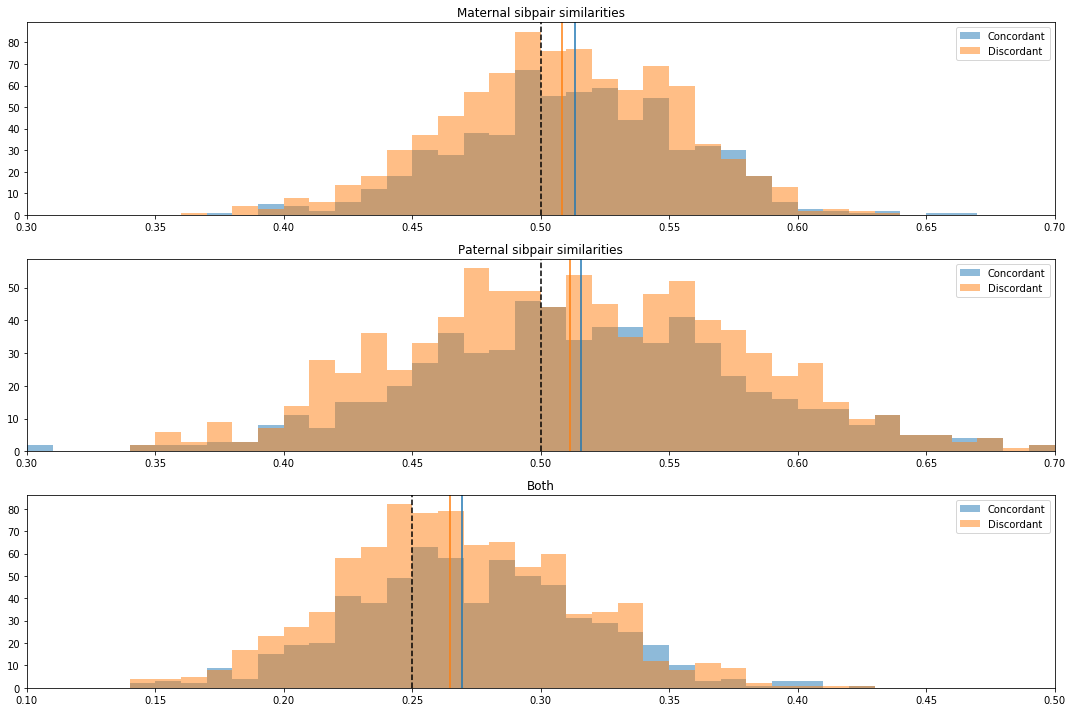

In [29]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 10))

print('Concordant', len(ihart_quad_mat_aff_aff))
print('Discordant', len(ihart_quad_mat_aff_unaff)+len(ssc_mat_aff_unaff))

plt.subplot(3, 1, 1)
plt.title('Maternal sibpair similarities')
plt.hist(ihart_quad_mat_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='Concordant')
plt.hist(ihart_quad_mat_aff_unaff+ssc_mat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='Discordant')
plt.axvline(np.median(ihart_quad_mat_aff_aff+ihart_quad_mat_unaff_unaff), color=colors[0])
plt.axvline(np.median(ihart_quad_mat_aff_unaff+ssc_mat_aff_unaff), color=colors[1])
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0.3, 0.7])
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Paternal sibpair similarities')
plt.hist(ihart_quad_pat_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='Concordant')
plt.hist(ihart_quad_pat_aff_unaff+ssc_pat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='Discordant')

plt.axvline(np.median(ihart_quad_pat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_pat_aff_unaff+ssc_pat_aff_unaff), color=colors[1])
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0.3, 0.7])
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Both')
plt.hist(ihart_quad_both_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='Concordant')
plt.hist(ihart_quad_both_aff_unaff+ssc_both_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='Discordant')
plt.axvline(np.median(ihart_quad_both_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_both_aff_unaff+ssc_both_aff_unaff), color=colors[1])
plt.axvline(0.25, color='black', linestyle='--')
plt.xlim([0.1, 0.5])
plt.legend()

plt.tight_layout()
plt.show()



In [242]:
print('IHART + SSC')
print(stats.ttest_ind(ihart_quad_mat_aff_aff, ihart_quad_mat_aff_unaff+ssc_mat_aff_unaff, equal_var=True))
print(stats.ttest_ind(ihart_quad_pat_aff_aff, ihart_quad_pat_aff_unaff+ssc_pat_aff_unaff, equal_var=True))
print(stats.ttest_ind(ihart_quad_both_aff_aff, ihart_quad_both_aff_unaff+ssc_both_aff_unaff, equal_var=True))

print()
concordant = [(x+y)/2 for x, y in zip(ihart_quad_mat_aff_aff, ihart_quad_pat_aff_aff)]
disconcordant = [(x+y)/2 for x, y in zip(ihart_quad_mat_aff_unaff+ssc_mat_aff_unaff, ihart_quad_pat_aff_unaff+ssc_pat_aff_unaff)]

print('Concordant', np.mean(concordant), np.median(concordant))
print('Discordant', np.mean(disconcordant), np.median(disconcordant))



IHART + SSC
Ttest_indResult(statistic=2.114321262197531, pvalue=0.03465060943854046)
Ttest_indResult(statistic=1.3477499487012174, pvalue=0.1779400530255781)
Ttest_indResult(statistic=1.99288807362178, pvalue=0.04645259291602157)

Concordant 0.5148832622426159 0.5137883659779888
Discordant 0.5102085276240053 0.5092065978922165


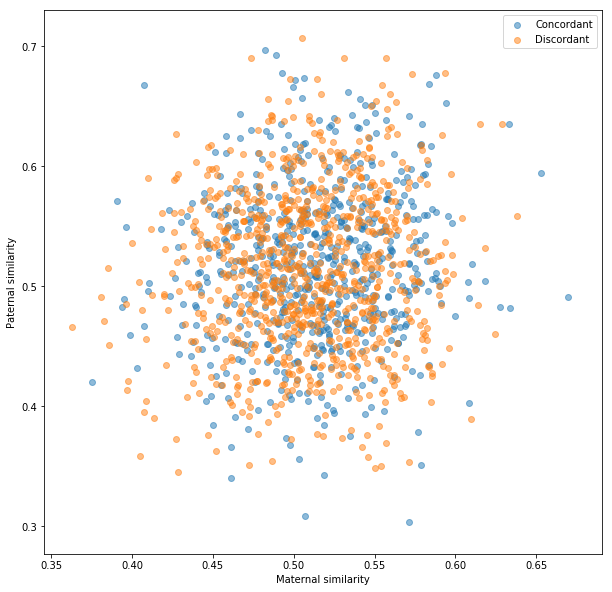

In [243]:
plt.figure(figsize=(10, 10))
plt.scatter(ihart_quad_mat_aff_aff, ihart_quad_pat_aff_aff, alpha=0.5, label='Concordant')
plt.scatter(ihart_quad_mat_aff_unaff+ssc_mat, ihart_quad_pat_aff_unaff+ssc_pat, alpha=0.5, label='Discordant')
plt.xlabel('Maternal similarity')
plt.ylabel('Paternal similarity')
plt.legend()

plt.show()

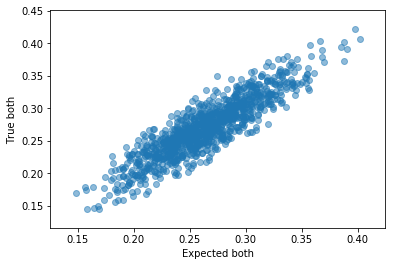

In [244]:
plt.scatter([(x*y) for z, x, y in zip(ihart_sps_keys, ihart_quad_mat,ihart_quad_pat) if z not in ihart_quad_outliers], 
            [x for z, x in zip(ihart_sps_keys, ihart_quad_both) if z not in ihart_quad_outliers], alpha=0.5)
plt.xlabel('Expected both')
plt.ylabel('True both')
plt.show()

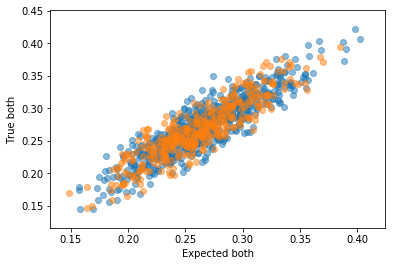

In [245]:
plt.scatter([(x*y) for x, y in zip(ihart_quad_mat_aff_aff, ihart_quad_pat_aff_aff)], ihart_quad_both_aff_aff, alpha=0.5)

plt.scatter([(x*y) for x, y in zip(ihart_quad_mat_aff_unaff, ihart_quad_pat_aff_unaff)], ihart_quad_both_aff_unaff, alpha=0.5)
plt.xlabel('Expected both')
plt.ylabel('True both')
plt.show()

# Now look at simple repeat regions

In [165]:
ihart_quad_sr_sps = calculate_sibpair_similarity(ihart_quad_intervals, ok_ihart_quad_families, weights=ihart_quad_weights)

ihart_quad_sr_mat = [0 if x is None else x.shared['mat_same']/(x.shared['mat_same']+x.shared['mat_diff']) for x in [None if y not in ihart_quad_sr_sps else ihart_quad_sr_sps[y] for y in ihart_sps_keys]]
ihart_quad_sr_pat = [0 if x is None else x.shared['pat_same']/(x.shared['pat_same']+x.shared['pat_diff']) for x in [None if y not in ihart_quad_sr_sps else ihart_quad_sr_sps[y] for y in ihart_sps_keys]]
ihart_quad_sr_both = [0 if x is None else x.shared['both_same']/(x.shared['both_same']+x.shared['both_diff']) for x in [None if y not in ihart_quad_sr_sps else ihart_quad_sr_sps[y] for y in ihart_sps_keys]]



In [166]:
ssc_sr_sps = calculate_sibpair_similarity(ssc_intervals, ok_ssc_families, weights=ssc_weights)

ssc_sr_mat = [x.shared['mat_same']/(x.shared['mat_same']+x.shared['mat_diff']) for x in [ssc_sr_sps[y] for y in ssc_sps_keys]]
ssc_sr_pat = [x.shared['pat_same']/(x.shared['pat_same']+x.shared['pat_diff']) for x in [ssc_sr_sps[y] for y in ssc_sps_keys]]
ssc_sr_both = [x.shared['both_same']/(x.shared['both_same']+x.shared['both_diff']) for x in [ssc_sr_sps[y] for y in ssc_sps_keys]]


KeyError: UUID('73efcfb4-c8ad-47ac-9c76-2dcac6e6a18a')

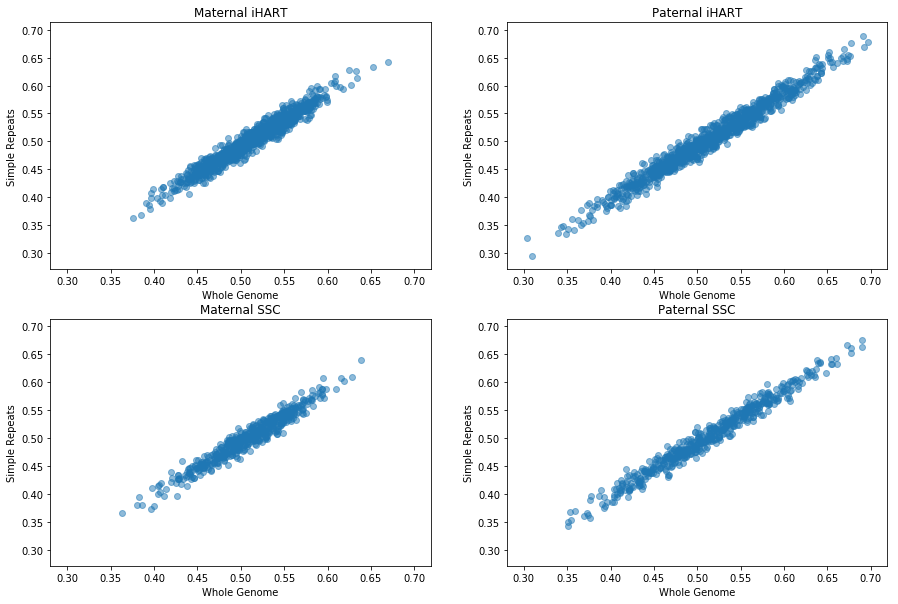

In [167]:
plt.figure(figsize=(15, 10))

a = plt.subplot(2, 2, 1)
#plt.hexbin([x for z, x in zip(ihart_sps_keys, ihart_quad_mat) if z not in ihart_outliers and z not in ihart_quad_outliers],
#           [x for z, x in zip(ihart_sps_keys, ihart_quad_sr_mat) if z not in ihart_outliers and z not in ihart_quad_outliers], 
#           gridsize=35)
plt.scatter([x for z, x in zip(ihart_sps_keys, ihart_quad_mat) if z not in ihart_outliers and z not in ihart_quad_outliers],
           [x for z, x in zip(ihart_sps_keys, ihart_quad_sr_mat) if z not in ihart_outliers and z not in ihart_quad_outliers], 
           alpha=0.5)
plt.title('Maternal iHART')
plt.xlabel('Whole Genome')
plt.ylabel('Simple Repeats')

plt.subplot(2, 2, 2, sharex=a, sharey=a)
#plt.hexbin([x for z, x in zip(ihart_sps_keys, ihart_quad_pat) if z not in ihart_outliers and z not in ihart_quad_outliers],
#           [x for z, x in zip(ihart_sps_keys, ihart_quad_sr_pat) if z not in ihart_outliers and z not in ihart_quad_outliers], 
#           gridsize=35)
plt.scatter([x for z, x in zip(ihart_sps_keys, ihart_quad_pat) if z not in ihart_outliers and z not in ihart_quad_outliers],
           [x for z, x in zip(ihart_sps_keys, ihart_quad_sr_pat) if z not in ihart_outliers and z not in ihart_quad_outliers], 
           alpha=0.5)

plt.title('Paternal iHART')
plt.xlabel('Whole Genome')
plt.ylabel('Simple Repeats')

plt.subplot(2, 2, 3, sharex=a, sharey=a)
#plt.hexbin([x for z, x in zip(ssc_sps_keys, ssc_mat) if z not in ssc_outliers],
#           [x for z, x in zip(ssc_sps_keys, ssc_sr_mat) if z not in ssc_outliers], 
#           gridsize=35)
plt.scatter([x for z, x in zip(ssc_sps_keys, ssc_mat) if z not in ssc_outliers],
            [x for z, x in zip(ssc_sps_keys, ssc_sr_mat) if z not in ssc_outliers], 
           alpha=0.5)

plt.title('Maternal SSC')
plt.xlabel('Whole Genome')
plt.ylabel('Simple Repeats')

plt.subplot(2, 2, 4, sharex=a, sharey=a)
#plt.hexbin([x for z, x in zip(ssc_sps_keys, ssc_pat) if z not in ssc_outliers],
#           [x for z, x in zip(ssc_sps_keys, ssc_sr_pat) if z not in ssc_outliers], 
#           gridsize=35)
plt.scatter([x for z, x in zip(ssc_sps_keys, ssc_pat) if z not in ssc_outliers],
           [x for z, x in zip(ssc_sps_keys, ssc_sr_pat) if z not in ssc_outliers], 
           alpha=0.5)
plt.title('Paternal SSC')
plt.xlabel('Whole Genome')
plt.ylabel('Simple Repeats')

plt.show()



iHART quad aff-aff 643
iHART quad aff-unaff 361
iHART quad unaff-unaff 19
SSC aff-unaff 515


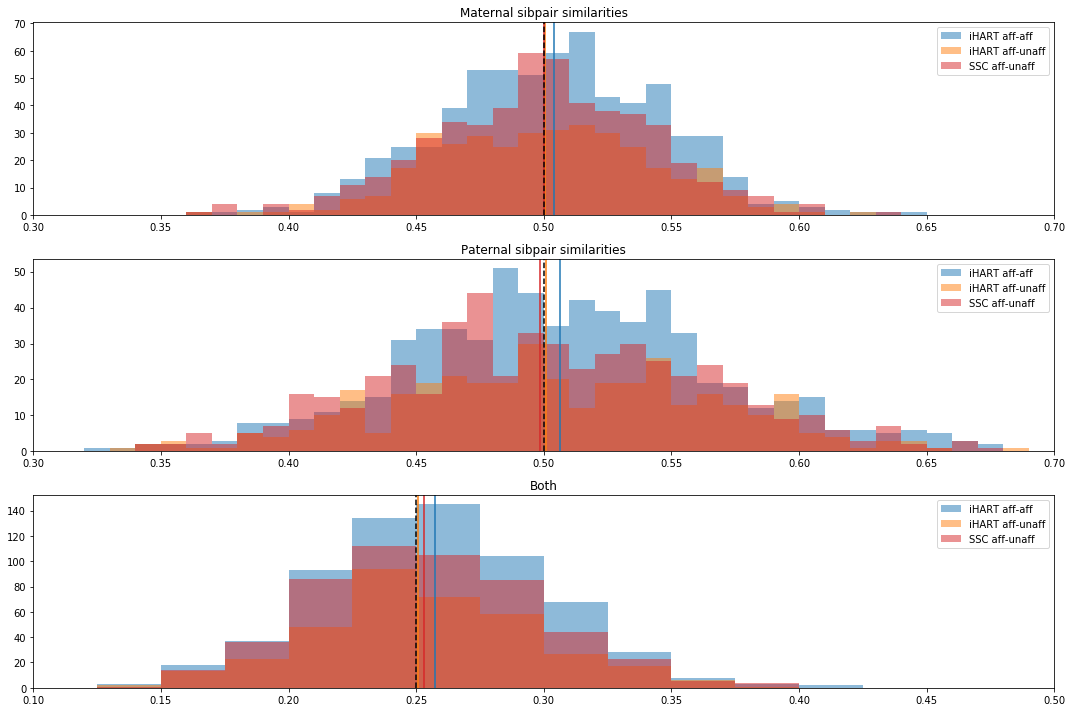

In [168]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 10))

ihart_quad_sr_mat_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_quad_sr_mat) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2' and x not in ihart_quad_outliers]
ihart_quad_sr_mat_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_sr_mat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1'))  and x not in ihart_quad_outliers]
ihart_quad_sr_mat_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_sr_mat) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1'  and x not in ihart_quad_outliers]

ihart_quad_sr_pat_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_quad_sr_pat) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2' and x not in ihart_quad_outliers]
ihart_quad_sr_pat_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_sr_pat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ihart_quad_outliers]
ihart_quad_sr_pat_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_sr_pat) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1' and x not in ihart_quad_outliers]

ihart_quad_sr_both_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_quad_sr_both) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2' and x not in ihart_quad_outliers]
ihart_quad_sr_both_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_sr_both) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ihart_quad_outliers]
ihart_quad_sr_both_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_quad_sr_both) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1' and x not in ihart_quad_outliers]

ssc_sr_mat_aff_unaff = [m for x, m in zip(ssc_sps_keys, ssc_sr_mat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ssc_outliers]
ssc_sr_pat_aff_unaff = [m for x, m in zip(ssc_sps_keys, ssc_sr_pat) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ssc_outliers]
ssc_sr_both_aff_unaff = [m for x, m in zip(ssc_sps_keys, ssc_sr_both) if ((child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')) and x not in ssc_outliers]

print('iHART quad aff-aff', len(ihart_quad_sr_mat_aff_aff))
print('iHART quad aff-unaff', len(ihart_quad_sr_mat_aff_unaff))
print('iHART quad unaff-unaff', len(ihart_quad_sr_mat_unaff_unaff))
print('SSC aff-unaff', len(ssc_sr_mat_aff_unaff))

plt.subplot(3, 1, 1)
plt.title('Maternal sibpair similarities')
plt.hist(ihart_quad_sr_mat_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_quad_sr_mat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART aff-unaff')
#plt.hist(ihart_quad_sr_mat_unaff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_sr_mat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, color=colors[3], label='SSC aff-unaff')
plt.axvline(np.median(ihart_quad_sr_mat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_sr_mat_aff_unaff), color=colors[1])
#plt.axvline(np.median(ihart_quad_sr_mat_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_sr_mat_aff_unaff), color=colors[3])

#plt.axvline(np.median(ihart_quad_mat_aff_aff+ihart_quad_mat_unaff_unaff+ihart_quad_mat_aff_unaff+ssc_mat_aff_unaff), color='black')
#plt.axvline(np.median(ihart_quad_mat_aff_unaff+ssc_mat_aff_unaff), color='white')
#plt.axvline(np.median(ihart_quad_mat_aff_aff+ihart_quad_mat_unaff_unaff), color='gray')

plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0.3, 0.7])

#m = 0.5
#s = max(np.std(ihart_mat_aff_aff), np.std(ihart_mat_aff_unaff), np.std(ssc_mat_aff_unaff))
#n = min(len(ihart_mat_aff_aff), len(ihart_mat_aff_unaff), len(ssc_mat_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.subplot(3, 1, 2)
plt.title('Paternal sibpair similarities')
plt.hist(ihart_quad_sr_pat_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_quad_sr_pat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART aff-unaff')
#plt.hist(ihart_quad_sr_pat_unaff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_sr_pat_aff_unaff, bins=np.arange(0, 1, .01), color=colors[3], alpha=0.5, label='SSC aff-unaff')

plt.axvline(np.median(ihart_quad_sr_pat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_sr_pat_aff_unaff), color=colors[1])
#plt.axvline(np.median(ihart_quad_sr_pat_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_sr_pat_aff_unaff), color=colors[3])

#plt.axvline(np.median(ihart_quad_pat_aff_aff+ihart_quad_pat_unaff_unaff+ihart_quad_pat_aff_unaff+ssc_pat_aff_unaff), color='black')
#plt.axvline(np.median(ihart_quad_pat_aff_unaff+ssc_pat_aff_unaff), color='white')
#plt.axvline(np.median(ihart_quad_pat_aff_aff+ihart_quad_pat_unaff_unaff), color='gray')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0.3, 0.7])

#m = 0.5
#s = max(np.std(ihart_pat_aff_aff), np.std(ihart_pat_aff_unaff), np.std(ssc_pat_aff_unaff))
#n = min(len(ihart_pat_aff_aff), len(ihart_pat_aff_unaff), len(ssc_pat_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.subplot(3, 1, 3)
plt.title('Both')
plt.hist(ihart_quad_sr_both_aff_aff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_quad_sr_both_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-unaff')
#plt.hist(ihart_quad_sr_both_unaff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_sr_both_aff_unaff, bins=np.arange(0, 1, .025), color=colors[3], alpha=0.5, label='SSC aff-unaff')
plt.axvline(np.median(ihart_quad_sr_both_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_sr_both_aff_unaff), color=colors[1])
#plt.axvline(np.median(ihart_quad_sr_both_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_sr_both_aff_unaff), color=colors[3])

#plt.axvline(np.median(ihart_quad_both_aff_aff+ihart_quad_both_unaff_unaff+ihart_quad_both_aff_unaff+ssc_both_aff_unaff), color='black')
#plt.axvline(np.median(ihart_quad_both_aff_unaff+ssc_both_aff_unaff), color='white')
#plt.axvline(np.median(ihart_quad_both_aff_aff+ihart_quad_both_unaff_unaff), color='gray')

plt.axvline(0.25, color='black', linestyle='--')
plt.xlim([0.1, 0.5])

#m = 0.25
#s = max(np.std(ihart_both_aff_aff), np.std(ihart_both_aff_unaff), np.std(ssc_both_aff_unaff))
#n = min(len(ihart_both_aff_aff), len(ihart_both_aff_unaff), len(ssc_both_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.tight_layout()
plt.show()



In [169]:
print(min(ihart_quad_sr_mat_aff_aff), max(ihart_quad_sr_mat_aff_aff))
print(min(ihart_quad_sr_mat_aff_unaff), max(ihart_quad_sr_mat_aff_unaff))
print(min(ssc_sr_mat_aff_unaff), max(ssc_sr_mat_aff_unaff))

0.36219508508770576 0.6420993578917649
0.36800311063686225 0.6277889776259445
0.3646715741637052 0.63945236632571


Concordant 662
Discordant 876


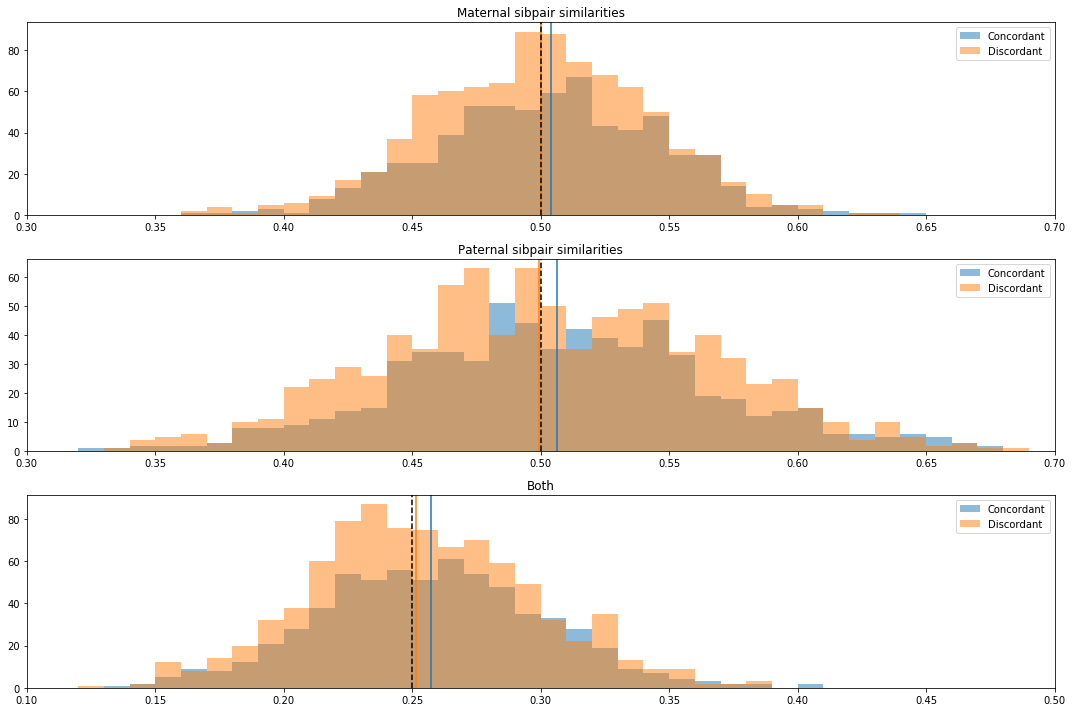

In [170]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 10))

print('Concordant', len(ihart_quad_sr_mat_aff_aff)+len(ihart_quad_sr_mat_unaff_unaff))
print('Discordant', len(ihart_quad_sr_mat_aff_unaff)+len(ssc_sr_mat_aff_unaff))

plt.subplot(3, 1, 1)
plt.title('Maternal sibpair similarities')
plt.hist(ihart_quad_sr_mat_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='Concordant')
plt.hist(ihart_quad_sr_mat_aff_unaff+ssc_sr_mat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='Discordant')
plt.axvline(np.median(ihart_quad_sr_mat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_sr_mat_aff_unaff+ssc_sr_mat_aff_unaff), color=colors[1])
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0.3, 0.7])
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Paternal sibpair similarities')
plt.hist(ihart_quad_sr_pat_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='Concordant')
plt.hist(ihart_quad_sr_pat_aff_unaff+ssc_sr_pat_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='Discordant')

plt.axvline(np.median(ihart_quad_sr_pat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_sr_pat_aff_unaff+ssc_sr_pat_aff_unaff), color=colors[1])
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0.3, 0.7])
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Both')
plt.hist(ihart_quad_sr_both_aff_aff, bins=np.arange(0, 1, .01), alpha=0.5, label='Concordant')
plt.hist(ihart_quad_sr_both_aff_unaff+ssc_sr_both_aff_unaff, bins=np.arange(0, 1, .01), alpha=0.5, label='Discordant')
plt.axvline(np.median(ihart_quad_sr_both_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_quad_sr_both_aff_unaff+ssc_sr_both_aff_unaff), color=colors[1])
plt.axvline(0.25, color='black', linestyle='--')
plt.xlim([0.1, 0.5])
plt.legend()

plt.tight_layout()
plt.show()



In [171]:
print('IHART + SSC')
print('Mat', stats.ttest_ind(ihart_quad_sr_mat_aff_aff, ihart_quad_sr_mat_aff_unaff+ssc_sr_mat_aff_unaff, equal_var=True))
print('Pat', stats.ttest_ind(ihart_quad_sr_pat_aff_aff, ihart_quad_sr_pat_aff_unaff+ssc_sr_pat_aff_unaff, equal_var=True))
print('Both', stats.ttest_ind(ihart_quad_sr_both_aff_aff, ihart_quad_sr_both_aff_unaff+ssc_sr_both_aff_unaff, equal_var=True))


IHART + SSC
Mat Ttest_indResult(statistic=1.6352391317953316, pvalue=0.1022063871976915)
Pat Ttest_indResult(statistic=1.3827503675708737, pvalue=0.16694492659001292)
Both Ttest_indResult(statistic=1.6034077317146602, pvalue=0.10905283291145897)


# Why is whole genome skewed right but not simple repeats?
It's possible that certain areas of the chromosome (centromere/telomere?) are more likely to be labeled inherited together than other regions - let's look. For this analysis, we focus only on the quad families.



In [261]:
from itertools import chain

all_positions = set()
for inter in chain.from_iterable(ihart_quad_intervals.values()):
    all_positions.add((inter.chrom, inter.start_pos))
    all_positions.add((inter.chrom, inter.end_pos))
print(len(all_positions))

1754131


In [262]:
telomeres, centromeres = [], []

with open('../data/centromere_telomere_grch37_ucsc.txt') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split()
        chrom, start_pos, end_pos = pieces[1][3:], int(pieces[2]), int(pieces[3])
        if chrom != 'X' and chrom != 'Y':
            if pieces[7] == 'telomere':
                telomeres.append((chrom, start_pos, end_pos))
            elif pieces[7] == 'centromere':
                centromeres.append((chrom, start_pos, end_pos))

In [263]:
all_positions = sorted(all_positions, key=lambda x: (int(x[0]), x[1]))
print(all_positions[-5:])
pos_to_index = dict([(v, k) for k, v in enumerate(all_positions)])

[('22', 51233009), ('22', 51233010), ('22', 51265784), ('22', 51265785), ('22', 51304566)]


In [264]:
import numpy as np

# Interval = namedtuple('Interval', ['id', 'chrom', 'start_pos', 'end_pos', 'length', 'has_m1', 'has_m2', 'has_p1', 'has_p2', 'm_unknown', 'p_unknown'])

inheritance_pattern = np.zeros((len(all_positions), 3), dtype=int) # together, different, unknown

for inter in chain.from_iterable(ihart_quad_intervals.values()):
    start_index, end_index = pos_to_index[(inter.chrom, inter.start_pos)], pos_to_index[(inter.chrom, inter.end_pos)]+1
    if (len(inter.has_m1) == 2) or (len(inter.has_m2) == 2):
        inheritance_pattern[start_index:end_index, 0] += 1
    elif (len(inter.has_m1) == 1) and (len(inter.has_m2) == 1):
        inheritance_pattern[start_index:end_index, 1] += 1
    else:
        inheritance_pattern[start_index:end_index, 2] += 1
    
    

In [265]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}

chrom_start = dict([(x, sum([chrom_lengths[str(y)] for y in range(1, int(x))])) for x in chroms])
print(chrom_start)

{'1': 0, '2': 249250621, '3': 492449994, '4': 690472424, '5': 881626700, '6': 1062541960, '7': 1233657027, '8': 1392795690, '9': 1539159712, '10': 1680373143, '11': 1815907890, '12': 1950914406, '13': 2084766301, '14': 2199936179, '15': 2307285719, '16': 2409817111, '17': 2500171864, '18': 2581367074, '19': 2659444322, '20': 2718573305, '21': 2781598825, '22': 2829728720}


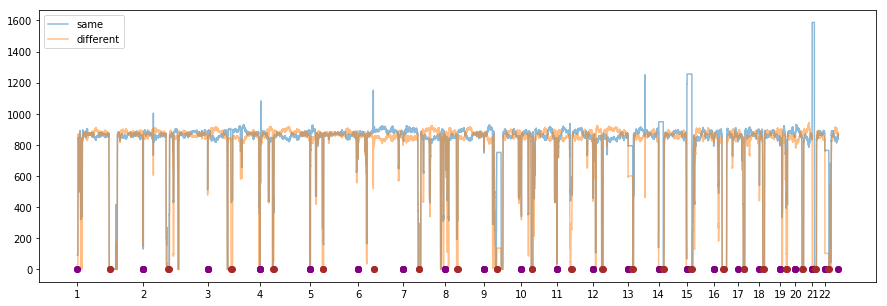

In [266]:
plt.figure(figsize=(15, 5))

xpos = [chrom_start[p[0]]+p[1] for p in all_positions]
plt.plot(xpos, inheritance_pattern[:, 0], label='same', alpha=0.5)
plt.plot(xpos, inheritance_pattern[:, 1], label='different', alpha=0.5)
#plt.plot(xpos, inheritance_pattern[:, 2], label='unknown', alpha=0.5)

plt.legend()

# plot centromeres and telomeres
for chrom, start_pos, end_pos in telomeres:
    plt.plot(chrom_start[chrom]+start_pos, 0, chrom_start[chrom]+end_pos, 0, marker = 'o', color='purple')
for chrom, start_pos, end_pos in centromeres:
    plt.plot(chrom_start[chrom]+start_pos, 0, chrom_start[chrom]+end_pos, 0, marker = 'o', color='brown')


plt.xticks([chrom_start[chrom] for chrom in chroms], chroms)
plt.show()

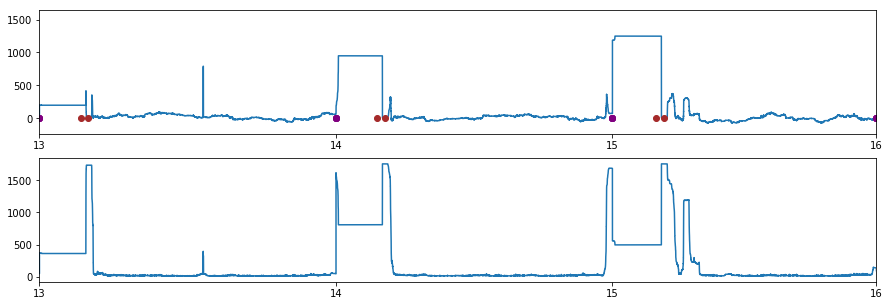

In [270]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
xpos = [chrom_start[p[0]]+p[1] for p in all_positions]
plt.plot(xpos, inheritance_pattern[:, 0]-inheritance_pattern[:, 1])


# plot centromeres and telomeres
for chrom, start_pos, end_pos in telomeres:
    plt.plot(chrom_start[chrom]+start_pos, 0, chrom_start[chrom]+end_pos, 0, marker = 'o', color='purple')
for chrom, start_pos, end_pos in centromeres:
    plt.plot(chrom_start[chrom]+start_pos, 0, chrom_start[chrom]+end_pos, 0, marker = 'o', color='brown')


plt.xticks([chrom_start[chrom] for chrom in chroms], chroms)
plt.xlim([chrom_start['13'], chrom_start['16']])

plt.subplot(2, 1, 2)
plt.plot(xpos, inheritance_pattern[:, 2])
plt.xticks([chrom_start[chrom] for chrom in chroms], chroms)
plt.xlim([chrom_start['13'], chrom_start['16']])

plt.show()

(array([273.,  25.,   7.,   2.,   3.,   0.,   1.,   0.,   0.,   1.]),
 array([1.00000e+00, 6.54450e+03, 1.30880e+04, 1.96315e+04, 2.61750e+04,
        3.27185e+04, 3.92620e+04, 4.58055e+04, 5.23490e+04, 5.88925e+04,
        6.54360e+04]),
 <a list of 10 Patch objects>)

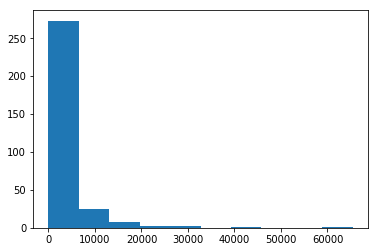

In [253]:
peak_starts = np.where((inheritance_pattern[:-1, 0]-inheritance_pattern[:-1, 1] <= 100) & \
                      (inheritance_pattern[1:, 0]-inheritance_pattern[1:, 1] > 100))[0]
peak_ends = np.where((inheritance_pattern[:-1, 0]-inheritance_pattern[:-1, 1] > 100) & \
                      (inheritance_pattern[1:, 0]-inheritance_pattern[1:, 1] <= 100))[0]
peak_lengths = [y-x for x, y in zip(peak_starts, peak_ends)]

plt.hist(peak_lengths)

In [225]:
(inheritance_pattern[:-1, 0]-inheritance_pattern[:-1, 1] <= 100).shape

(1423571,)